In [ ]:
import pandas as pd
import os
from typing import Iterator, Generator, List, Dict

# --- Constantes ---
CSV_FILE_PATH = None
CHUNK_SIZE = 100000  # Définir une taille de morceau (par exemple, 100 000 lignes)

def process_csv_by_chunks(path: str, chunk_size: int) -> List[pd.DataFrame] | None:
    """
    Charge un fichier CSV par morceaux, traite chaque morceau,
    et retourne une liste des DataFrames traités.

    Args:
        path (str): Le chemin vers le fichier CSV.
        chunk_size (int): Le nombre de lignes à lire à la fois.

    Returns:
        List[pd.DataFrame] | None: Une liste des DataFrames traités, ou None en cas d'erreur.
    """

    print(f"Tentative de chargement du fichier : {os.path.abspath(path)}")
    print(f"Chargement par morceaux de taille : {chunk_size} lignes.")

    if not os.path.exists(path):
        print(f"Erreur: Le fichier '{path}' est introuvable. Vérifiez le chemin d'accès.")
        return None

    processed_chunks = []
    chunk_index = 0

    try:
        # Créer un itérateur (TextFileReader) au lieu d'un DataFrame unique
        csv_iterator = pd.read_csv(path, chunksize=chunk_size)

        # Parcourir les morceaux générés par l'itérateur
        for chunk in csv_iterator:
            chunk_index += 1
            print(f"Traitement du morceau #{chunk_index} (taille: {len(chunk)} lignes)...")

            # 💡 --- Zone de Traitement des Données --- 💡
            # Ici, vous pouvez appliquer des opérations qui réduisent la taille du morceau,
            # comme le filtrage, l'agrégation ou le calcul de statistiques.

            # Exemple : Calculer la moyenne de toutes les colonnes et stocker
            # stats_df = chunk.mean().to_frame().T
            # processed_chunks.append(stats_df)

            # Exemple : Filtrer pour garder uniquement les lignes où 'col_A' > 10
            # filtered_chunk = chunk[chunk['col_A'] > 10]
            # processed_chunks.append(filtered_chunk)

            # --- Fin de la Zone de Traitement ---

            # Dans cet exemple, nous stockons le morceau complet filtré
            # Si vous avez 500Mo, vous DEVEZ faire un traitement pour réduire le morceau avant de l'ajouter
            # à 'processed_chunks', sinon vous resaturerez votre RAM.
            processed_chunks.append(chunk)


        print(f"\nChargement et traitement terminés. {chunk_index} morceaux traités.")

        # ⚠️ ATTENTION : La ligne suivante va CONSOLIDER TOUS les morceaux.
        # Si vous n'avez pas réduit la taille des morceaux, vous risquez une saturation RAM.
        # Si vous n'avez besoin que de statistiques, vous pouvez retourner processed_chunks directement.
        final_dataframe = pd.concat(processed_chunks, ignore_index=True)
        print(f"Taille du DataFrame final: {len(final_dataframe)} lignes.")
        return final_dataframe

    except Exception as e:
        print(f"Une erreur s'est produite lors du traitement du fichier CSV : {e}")
        return None

In [ ]:
F_train = process_csv_by_chunks("/content/drive/MyDrive/Colab Notebooks/raw_data/TEP_Faulty_Training.csv",
                                chunk_size=CHUNK_SIZE)

Tentative de chargement du fichier : /content/drive/MyDrive/Colab Notebooks/raw_data/TEP_Faulty_Training.csv
Chargement par morceaux de taille : 100000 lignes.
Traitement du morceau #1 (taille: 100000 lignes)...
Traitement du morceau #2 (taille: 100000 lignes)...
Traitement du morceau #3 (taille: 100000 lignes)...
Traitement du morceau #4 (taille: 100000 lignes)...
Traitement du morceau #5 (taille: 100000 lignes)...
Traitement du morceau #6 (taille: 100000 lignes)...
Traitement du morceau #7 (taille: 100000 lignes)...
Traitement du morceau #8 (taille: 100000 lignes)...
Traitement du morceau #9 (taille: 100000 lignes)...
Traitement du morceau #10 (taille: 100000 lignes)...
Traitement du morceau #11 (taille: 100000 lignes)...
Traitement du morceau #12 (taille: 100000 lignes)...
Traitement du morceau #13 (taille: 100000 lignes)...
Traitement du morceau #14 (taille: 100000 lignes)...
Traitement du morceau #15 (taille: 100000 lignes)...
Traitement du morceau #16 (taille: 100000 lignes)...
T

In [ ]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

# 1. Simulation des données
# (500 séquences, 500 pas de temps, 52 features)
X = F_train.drop(columns=['faultNumber', 'simulationRun', 'sample']) # Drop simulationRun and sample if they are not features
# 20 classes
y = F_train['faultNumber']

# 2. Préparation de la validation croisée
tscv = TimeSeriesSplit(n_splits=5)

print(f"Shape globale : {X.shape}")

# 3. Boucle d'entraînement
for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"\n--- Fold {fold+1} ---")

    # A. Découpage
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # B. Normalisation (L'étape critique avec 52 features)
    # On doit aplatir les données pour le scaler : (N_seq * Time, Features)
    # Cela permet de normaliser chaque feature indépendamment du temps

    num_features = X_train.shape[1]        # Number of features
    timesteps_per_sequence = 500 # Assuming 500 timesteps per sequence. PLEASE VERIFY.

    # Ensure training set has complete sequences by trimming excess rows
    num_rows_train_fold = X_train.shape[0]
    remainder_train = num_rows_train_fold % timesteps_per_sequence
    if remainder_train != 0:
        print(f"Warning: Trimming {remainder_train} rows from training set to ensure complete sequences.")
        X_train = X_train.iloc[:-remainder_train]
        y_train = y_train.iloc[:-remainder_train]
        num_rows_train_fold = X_train.shape[0]
    num_sequences_train_fold = num_rows_train_fold // timesteps_per_sequence

    # Ensure test set has complete sequences by trimming excess rows
    num_rows_test_fold = X_test.shape[0]
    remainder_test = num_rows_test_fold % timesteps_per_sequence
    if remainder_test != 0:
        print(f"Warning: Trimming {remainder_test} rows from test set to ensure complete sequences.")
        X_test = X_test.iloc[:-remainder_test]
        y_test = y_test.iloc[:-remainder_test]
        num_rows_test_fold = X_test.shape[0]
    num_sequences_test_fold = num_rows_test_fold // timesteps_per_sequence

    # Convert DataFrames to NumPy arrays before scaling and reshaping
    X_train_np = X_train.values
    X_test_np = X_test.values

    scaler = StandardScaler()

    # FIT only on TRAIN! The data is already in 2D (num_rows, num_features) for scaling.
    X_train_scaled_2d = scaler.fit_transform(X_train_np)
    # TRANSFORM on TEST (using stats from train)
    X_test_scaled_2d = scaler.transform(X_test_np)

    # Return to 3D for the RNN: (num_sequences, timesteps_per_sequence, num_features)
    X_train_final = X_train_scaled_2d.reshape(num_sequences_train_fold, timesteps_per_sequence, num_features)
    X_test_final = X_test_scaled_2d.reshape(num_sequences_test_fold, timesteps_per_sequence, num_features)

    print(f"Train shape: {X_train_final.shape}")
    print(f"Test shape:  {X_test_final.shape}")

    # C. Entraînement du modèle (Exemple Keras/TensorFlow)
    # model = create_rnn_model(input_shape=(500, 52), num_classes=20)
    # model.fit(X_train_final, y_train, validation_data=(X_test_final, y_test)...)

Shape globale : (5000000, 52)

--- Fold 1 ---
Train shape: (1666, 500, 52)
Test shape:  (1666, 500, 52)

--- Fold 2 ---
Train shape: (3333, 500, 52)
Test shape:  (1666, 500, 52)

--- Fold 3 ---
Train shape: (5000, 500, 52)
Test shape:  (1666, 500, 52)

--- Fold 4 ---
Train shape: (6666, 500, 52)
Test shape:  (1666, 500, 52)

--- Fold 5 ---
Train shape: (8333, 500, 52)
Test shape:  (1666, 500, 52)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np # Added numpy import

# Define n_time and n_feat based on the previous cell's context (WBB-ekr1GjHT)
# From kernel state: timesteps_per_sequence = 500, num_features = 52
n_time = 500
n_feat = 52

# Adjust y_train and y_test to match the number of sequences for the LSTM output.
# Assuming `faultNumber` is constant within a sequence and we need one label per sequence.
# Also, adjust labels to be 0-indexed for sparse_categorical_crossentropy (from 1-20 to 0-19).
# The y_train and y_test in kernel state are already trimmed Series from the last fold.
y_train_seq = y_train.iloc[::n_time] - 1
y_test_seq = y_test.iloc[::n_time] - 1

print("\n" + "="*60)
print("ENTRAÎNEMENT DU MODÈLE LSTM")
print("="*60)

model = keras.Sequential([
    layers.Input(shape=(n_time, n_feat)),
    layers.LSTM(128, return_sequences=True),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.LSTM(64),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(20, activation='softmax')  # 20 classes (0-19)
])

model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train_final, y_train_seq, # Use y_train_seq
    validation_data=(X_test_final, y_test_seq), # Use y_test_seq
    epochs=50,
    batch_size=32,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
    ]
)
# ====================================
# 4. ÉVALUATION
# ====================================

test_loss, test_acc = model.evaluate(X_test_final, y_test_seq, verbose=0) # Use y_test_seq
print(f"\nTEST ACCURACY : {test_acc:.4f}")

y_prob = model.predict(X_test_final, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

# Adjust class_labels and class_names for 0-indexed labels and proper display
class_labels = sorted(np.unique(y_test_seq)) # These will be 0-19
class_names = [f"Panne_{label+1}" for label in class_labels] # Map 0->Panne_1, 1->Panne_2, etc.

from sklearn.metrics import classification_report
print("\n" + classification_report(
    y_test_seq, y_pred, # Use y_test_seq
    labels=class_labels,
    target_names=class_names,
    zero_division=0
))

# Sauvegarde
model.save("lstm_fault_classifier_20classes.keras")
print("\n✓ Modèle sauvegardé : lstm_fault_classifier_20classes.keras")


ENTRAÎNEMENT DU MODÈLE LSTM
Epoch 1/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.2697 - loss: 2.4254 - val_accuracy: 0.0444 - val_loss: 5.4941 - learning_rate: 0.0010
Epoch 2/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.5725 - loss: 1.1811 - val_accuracy: 0.0018 - val_loss: 8.0333 - learning_rate: 0.0010
Epoch 3/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.6475 - loss: 0.9562 - val_accuracy: 0.0042 - val_loss: 11.2673 - learning_rate: 0.0010
Epoch 4/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.7697 - loss: 0.5975 - val_accuracy: 0.0456 - val_loss: 12.6688 - learning_rate: 0.0010
Epoch 5/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.8041 - loss: 0.4870 - val_accuracy: 0.0126 - val_loss: 11.2356 - learning_rate: 0.0010
Epoch 6/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.7988 - loss: 0.4891 - val_accuracy: 0.0330 - val_loss: 14.7385 - learning_rate: 0.0010
Epoch 7/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 11s

Confusion Matrix:
 [[ 0 83  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  1  0  0  0  0 71  0  0  0 10  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0 81  0  0  0  1  0]
 [ 0  0  0  0 68  0  0  8  0  0  0  7  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 83  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 12 71  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 31  0  6  0 17 26  0  2  0  0  0  1  0]
 [ 0  0  1  0  0  0  0  0  0  1  0  0  0  0 69  0  0  0 12  0]
 [ 0  0  4  0  0  0  0  1  2  2  0  0  0  0 58  0  0  0 16  0]
 [ 0  0  1  0  0  0  0  0  1  1  0  0  0  0 66  0  0  0 14  0]
 [ 0  0  0  0  0  0  0 13  0  6  0 50 12  1  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  4  0  3  0  2 71  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 83  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  1  0  0  0  0 71  0  0  0 11  0]
 [ 0  0  1  0  0  0  0  0  0  2  0  0  0  0 63  0  0  0 18  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  

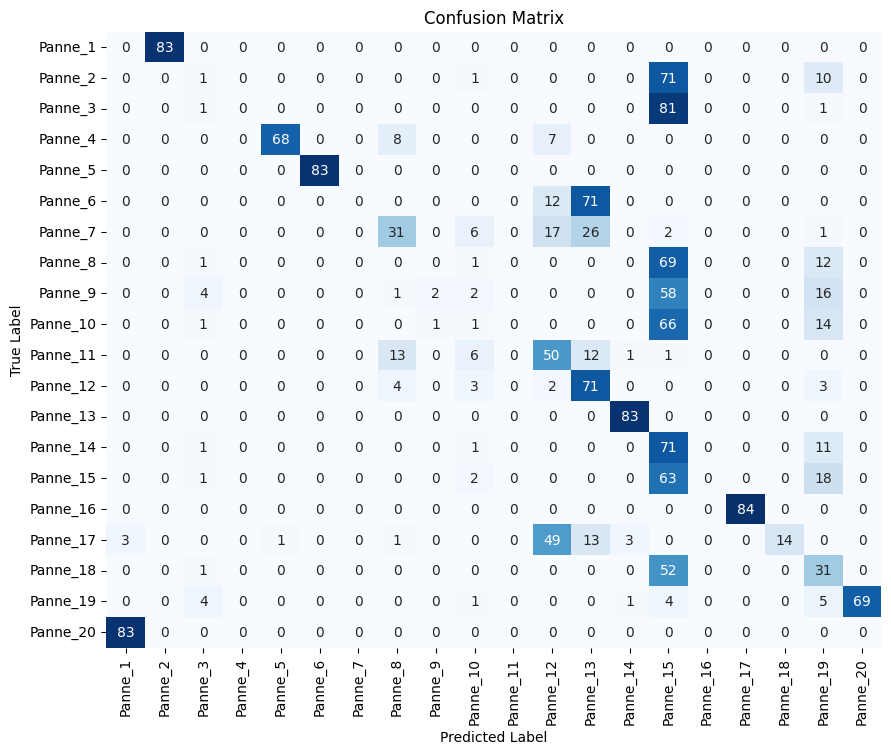

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_seq, y_pred)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=[f"Panne_{i+1}" for i in range(20)],
            yticklabels=[f"Panne_{i+1}" for i in range(20)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()